# Learning Partial Folding for better ZNE

In [5]:
import z2chain.circs as circs
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator, EstimatorOptions
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.transpiler import InstructionProperties, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passes.scheduling import ASAPScheduleAnalysis,PadDynamicalDecoupling
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import numpy as np
from fradm.token import _token

In [6]:
L = 8
J = 1
h = 0.05
lamb = 0.5

particle_pair_left_position = 3
particle_pair_length = 1

final_time = 5
layers = 50
measure_every_layers = 1

# backend = FakeTorino()
service = QiskitRuntimeService(channel='ibm_quantum', token=_token(), instance="ibm-q-ikerbasque/upv-ehu/quantum-many-bod")
# backend = service.backend('ibm_torino')
backend = service.least_busy()
print(backend.name)
seed = 10000

ibm_strasbourg


In [15]:
logical_circs = circs.particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, measure_every_layers)

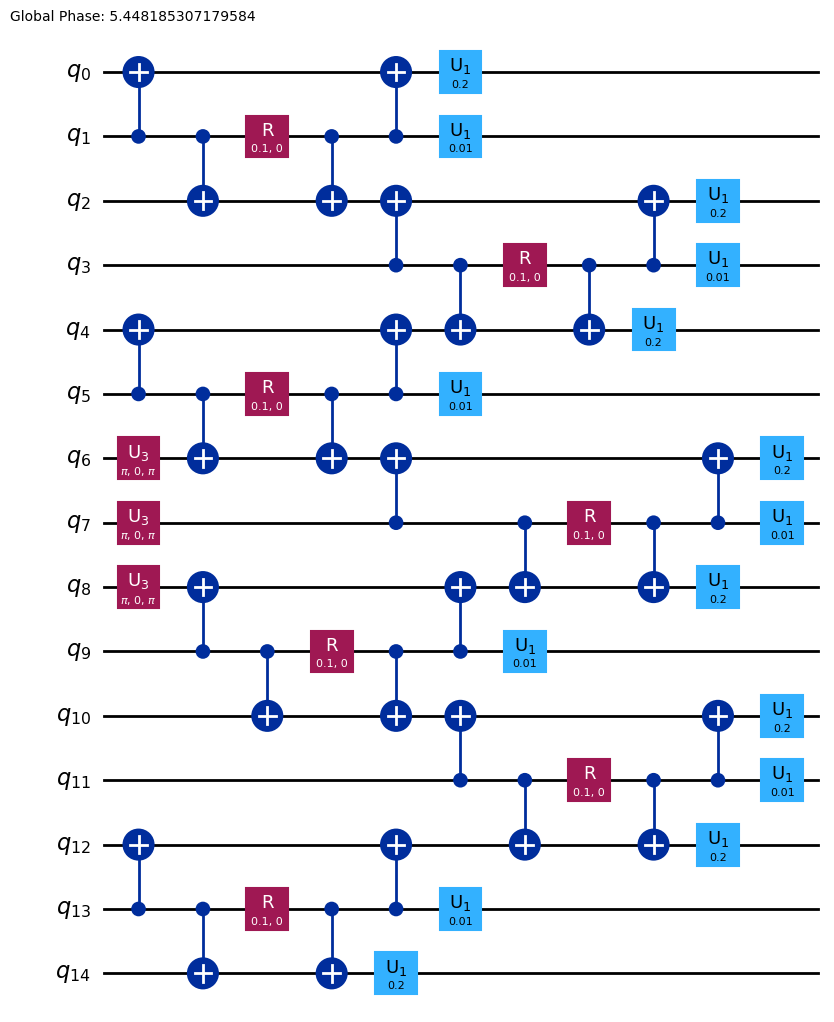

In [55]:
logical_circs[1].decompose(reps=1).draw(output='mpl', fold=-1)

In [63]:
ex_qc = logical_circs[5]
ex_qc.num_nonlocal_gates()
pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)
tr_lv3 = pm_lv3.run(ex_qc)
tr_lv3.depth()


152

In [22]:
def stats_optimized_circ(qc_transpiled, circ_depth, gt_counts, twoqugt_counts, optimization_level):
    circ_depth['opt_lv_'+f'{optimization_level}'] = sum([v for k,v in qc_transpiled.count_ops().items()])
    gt_counts['opt_lv_'+f'{optimization_level}'] = qc_transpiled.depth()
    twoqugt_counts['opt_lv_'+f'{optimization_level}'] = qc_transpiled.num_nonlocal_gates()

    print(f"Optimization level {optimization_level} results")
    print("====================")
    print("Circuit depth:", circ_depth['opt_lv_'+f'{optimization_level}'])
    print("Gate count:", gt_counts['opt_lv_'+f'{optimization_level}'])
    print("Non-local gates:", twoqugt_counts['opt_lv_'+f'{optimization_level}'])
    return circ_depth, gt_counts, twoqugt_counts

In [23]:
def score_for_a_layer_circuit(qc, backend, seed):
    circuit_depths = {
        'opt_lv_0': None,
        'opt_lv_1': None,
        'opt_lv_2': None,
        'opt_lv_3': None,
    }
    gate_counts = {
        'opt_lv_0': None,
        'opt_lv_1': None,
        'opt_lv_2': None,
        'opt_lv_3': None,
    }
    nnloc_gates = {
        'opt_lv_0': None,
        'opt_lv_1': None,
        'opt_lv_2': None,
        'opt_lv_3': None,
    }
    pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)
    pm_lv1 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
    pm_lv2 = generate_preset_pass_manager(backend=backend, optimization_level=2, seed_transpiler=seed)
    pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)

    # Run for our circuit
    tr_lv0 = pm_lv0.run(qc)
    tr_lv1 = pm_lv1.run(qc)
    tr_lv2 = pm_lv2.run(qc)
    tr_lv3 = pm_lv3.run(qc)
    

    circuit_depths, gate_counts, nnloc_gates = stats_optimized_circ(qc_transpiled=tr_lv0, circ_depth=circuit_depths, gt_counts=gate_counts,twoqugt_counts=nnloc_gates, optimization_level=0)
    circuit_depths, gate_counts, nnloc_gates = stats_optimized_circ(qc_transpiled=tr_lv1, circ_depth=circuit_depths, gt_counts=gate_counts,twoqugt_counts=nnloc_gates, optimization_level=1)
    circuit_depths, gate_counts, nnloc_gates = stats_optimized_circ(qc_transpiled=tr_lv2, circ_depth=circuit_depths, gt_counts=gate_counts,twoqugt_counts=nnloc_gates, optimization_level=2)
    circuit_depths, gate_counts, nnloc_gates = stats_optimized_circ(qc_transpiled=tr_lv3, circ_depth=circuit_depths, gt_counts=gate_counts,twoqugt_counts=nnloc_gates, optimization_level=3)
    return circuit_depths, gate_counts, nnloc_gates

In [24]:
circuit_depths, gate_counts, nnloc_gates = score_for_a_layer_circuit(qc=ex_qc, backend=backend, seed=seed)

Optimization level 0 results
Circuit depth: 495
Gate count: 64
Non-local gates: 56
Optimization level 1 results
Circuit depth: 229
Gate count: 44
Non-local gates: 56
Optimization level 2 results
Circuit depth: 224
Gate count: 44
Non-local gates: 56
Optimization level 3 results
Circuit depth: 226
Gate count: 46
Non-local gates: 56


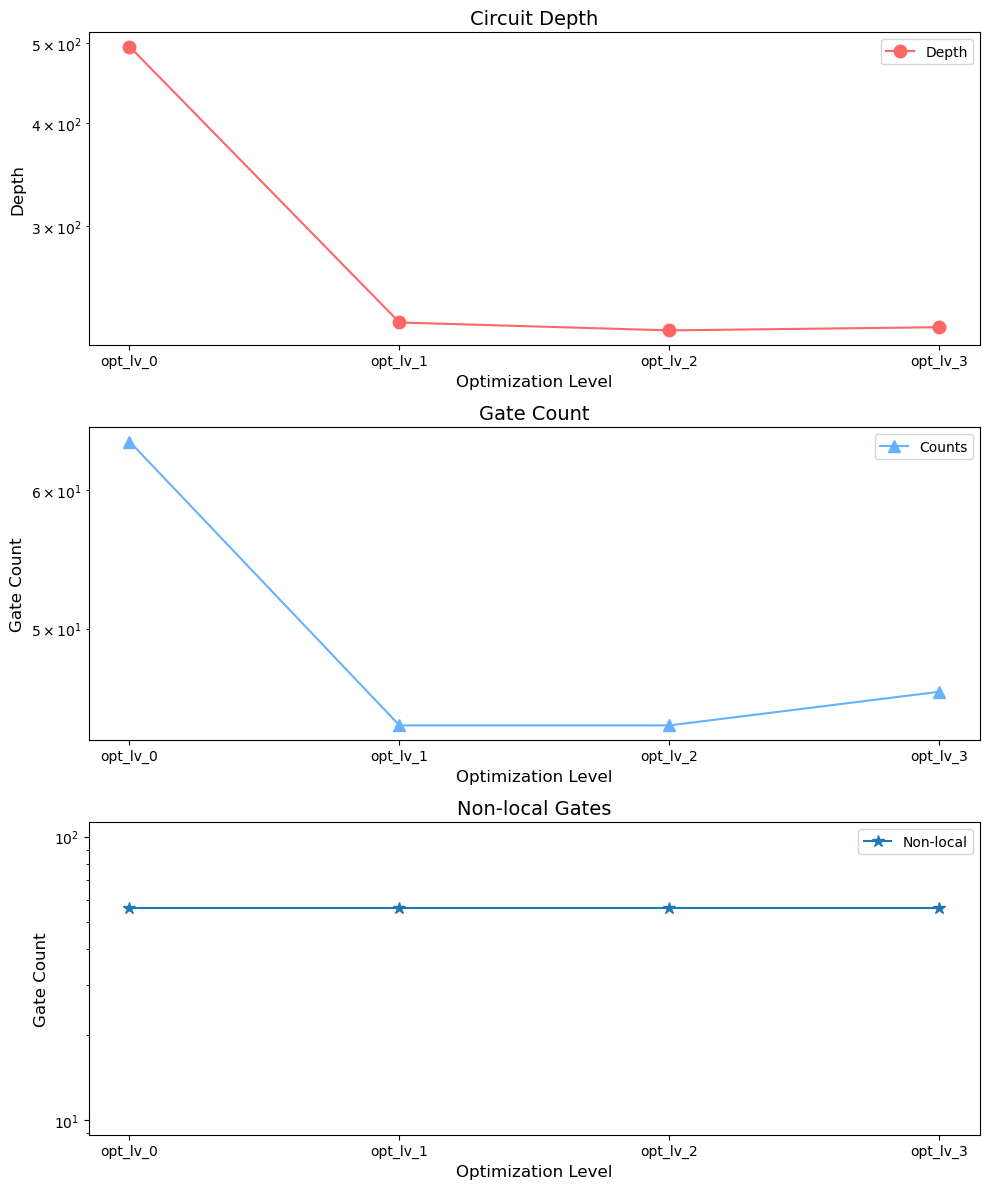

In [25]:
colors = ['#FF6666', '#66B2FF']
ax = ["opt_lv_0", "opt_lv_1", "opt_lv_2", "opt_lv_3"]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
ax1.semilogy(ax, [circuit_depths[key] for key in ax],'o-',markersize=9, color='#FF6666', label="Depth")
ax1.set_xlabel("Optimization Level", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
ax2.semilogy(ax, [gate_counts[key] for key in ax],'^-',markersize=9, color='#66B2FF', label="Counts")
ax2.set_xlabel("Optimization Level", fontsize=12)
ax2.set_ylabel("Gate Count", fontsize=12)
ax2.set_title("Gate Count", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
ax3.semilogy(ax, [nnloc_gates[key] for key in ax],'*-',markersize=9, label="Non-local")
ax3.set_xlabel("Optimization Level", fontsize=12)
ax3.set_ylabel("Gate Count", fontsize=12)
ax3.set_title("Non-local Gates", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

In [26]:
def best_opt_level(cds, gts, nnlgts):
    opt_lev_depth = np.argmin([depth for key, depth in cds.items()])
    opt_lev_gate_counts = np.argmin([gate_counts for key, gate_counts in gts.items()])
    opt_lev_nonloc = np.argmin([nonloc for key, nonloc in nnlgts.items()])
    return opt_lev_depth, opt_lev_gate_counts, opt_lev_nonloc

In [10]:
depths, counts, nonloc_counts = [], [], []
for logical_circ in logical_circs:
    circuit_depths, gate_counts, nnloc_gates = score_for_a_layer_circuit(qc=logical_circ, backend=backend, seed=seed)
    opt_lev_depth, opt_lev_gate_counts, opt_lev_nonloc = best_opt_level(circuit_depths, gate_counts, nnloc_gates)
    depths.append(opt_lev_depth)
    counts.append(opt_lev_gate_counts)
    nonloc_counts.append(opt_lev_nonloc)
    

Optimization level 0 results
Circuit depth: 3
Gate count: 1
Non-local gates: 0
Optimization level 1 results
Circuit depth: 3
Gate count: 1
Non-local gates: 0
Optimization level 2 results
Circuit depth: 3
Gate count: 1
Non-local gates: 0
Optimization level 3 results
Circuit depth: 3
Gate count: 1
Non-local gates: 0
Optimization level 0 results
Circuit depth: 249
Gate count: 33
Non-local gates: 28
Optimization level 1 results
Circuit depth: 119
Gate count: 23
Non-local gates: 28
Optimization level 2 results
Circuit depth: 129
Gate count: 26
Non-local gates: 28
Optimization level 3 results
Circuit depth: 131
Gate count: 28
Non-local gates: 28
Optimization level 0 results
Circuit depth: 495
Gate count: 64
Non-local gates: 56
Optimization level 1 results
Circuit depth: 229
Gate count: 44
Non-local gates: 56
Optimization level 2 results
Circuit depth: 224
Gate count: 44
Non-local gates: 56
Optimization level 3 results
Circuit depth: 224
Gate count: 44
Non-local gates: 56
Optimization level 0

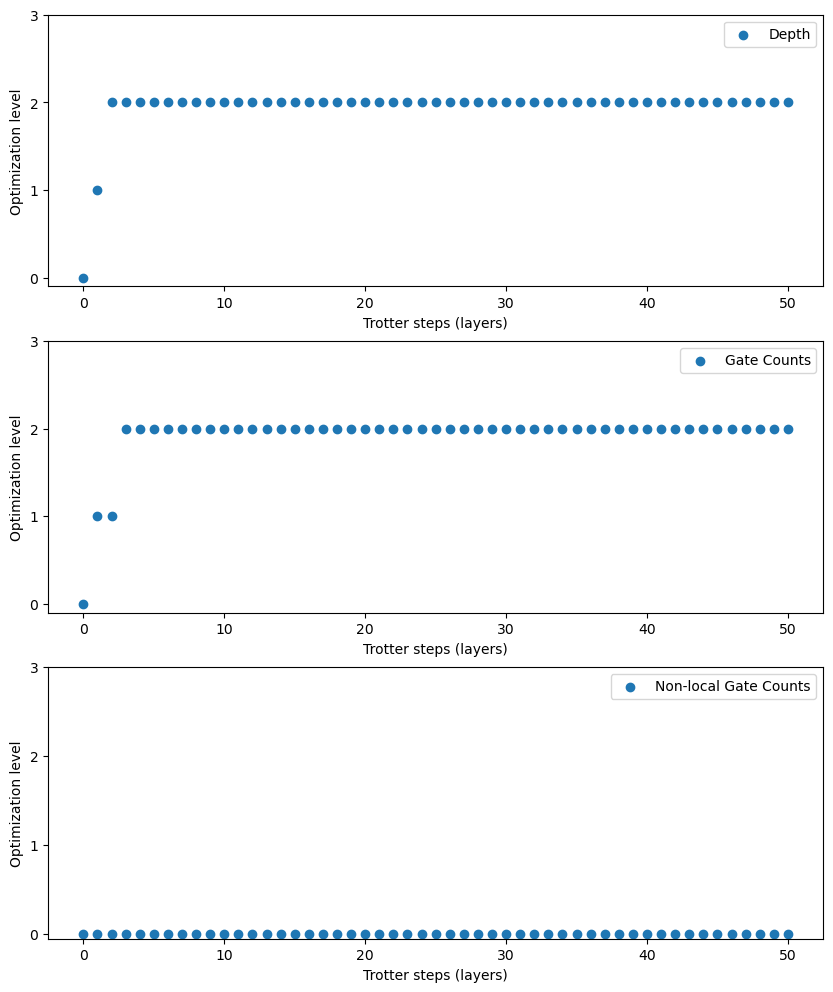

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.scatter(range(len(logical_circs)), depths, label="Depth")
ax2.scatter(range(len(logical_circs)), counts, label="Gate Counts")
ax3.scatter(range(len(logical_circs)), nonloc_counts, label="Non-local Gate Counts")
ax1.set_yticks(ticks=[0,1,2,3], labels=[0,1,2,3])
ax2.set_yticks(ticks=[0,1,2,3], labels=[0,1,2,3])
ax3.set_yticks(ticks=[0,1,2,3], labels=[0,1,2,3])
ax1.set_ylabel("Optimization level")
ax2.set_ylabel("Optimization level")
ax3.set_ylabel("Optimization level")
ax1.set_xlabel("Trotter steps (layers)")
ax2.set_xlabel("Trotter steps (layers)")
ax3.set_xlabel("Trotter steps (layers)")
ax1.legend()
ax2.legend()
ax3.legend()

In [40]:
def test_different_noise_mitigation_techniques(ansatzes, obs, options, backend):
    
    """Return the performance of the ansatzes

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        options (EstimatorOptions): Estimator options
        backend (service.backend): Backend to run the job 
        
    Returns:
        job_id (str): Job ID
    """

    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

    pubs = []
    for layer, ansatz in enumerate(ansatzes):

        print(f"Layer: {layer}")
        transpiled_circuit = pm.run(ansatz)
        transpiled_obs = obs.apply_layout(layout=transpiled_circuit.layout)
        pub = (transpiled_circuit, transpiled_obs)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
                       
    return job_id

Define the Observable

In [16]:
from utils.hexec import transpile

optimization_level = 2
backend = FakeTorino()
qubits_inds = None
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 34, 43]

physical_circuits = transpile(logical_circs, optimization_level, backend, qubits_inds)
print(f"Longest circuit contains {physical_circuits[-1].num_nonlocal_gates()} CNOT gates")

Longest circuit contains 1400 CNOT gates


In [35]:
from utils.hexec import execdb
from qiskit_ibm_runtime.options.utils import Unset

execution_database = "z2_chain_jobs.json"

default_shots = 10000
optimization_level = 0 # Deactivate error suppression
resilience_level = 0 # Deactivate error mitigation

dyn_dec = Unset # "XpXm", "XY4"
extra_slack = Unset # "middle"
scheduling = Unset # "alap"

zne_mitigation = False # False
extrapol = Unset # "linear"
measure_mitigation = False # False
num_rnd_res = Unset # None # 32
shots_rnd_res = Unset # None # "auto"
factor_noise = Unset # (1,3,5)

twirling_en_gt = Unset # False
twirling_en_meas = Unset # False
num_rnd_twrl = Unset # "auto"
shots_rnd_twrl = Unset # "auto"
strategy = Unset # "active-accum"

estimator_options = {
    "default_shots": default_shots,
    "optimization_level": optimization_level,
    "resilience_level": resilience_level,
    "dynamical_decoupling": {
                                "enable": bool(dyn_dec),
                                "sequence_type": dyn_dec,
                                "extra_slack_distribution": extra_slack,
                                "scheduling_method": scheduling,
                            },
    "resilience":           {
                                "measure_mitigation": measure_mitigation,
                                "zne_mitigation": zne_mitigation,
                                "measure_noise_learning":   {
                                                                "num_randomizations": num_rnd_res,
                                                                "shots_per_randomization": shots_rnd_res,
                                                            },
                                "zne":                      {
                                                                "noise_factors": factor_noise,
                                                                "extrapolator": extrapol
                                                            }
                            },
    "twirling":             {
                                "enable_gates": twirling_en_gt,
                                "enable_measure": twirling_en_meas,
                                "num_randomizations": num_rnd_twrl,
                                "shots_per_randomization": shots_rnd_twrl,
                                "strategy": strategy
                            }
}

job_db = execdb(execution_database)

In [36]:
from z2chain.qiskit_observables import local_pauli_z
from functools import partial

observable_name = "Occupation numbers"
observable_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]

In [37]:
from utils.hexec import execute_estimator_batch
jobs = execute_estimator_batch(backend, estimator_options, physical_circuits, observable_generating_funcs)

/Users/fradm98/opt/anaconda3/envs/qs_qh/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


ValidationError: 10 validation errors for EstimatorOptions
dynamical_decoupling.DynamicalDecouplingOptions.sequence_type.is-instance[UnsetType]
  Input should be an instance of UnsetType [type=is_instance_of, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/is_instance_of
dynamical_decoupling.DynamicalDecouplingOptions.sequence_type.literal['XX','XpXm','XY4']
  Input should be 'XX', 'XpXm' or 'XY4' [type=literal_error, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/literal_error
dynamical_decoupling.is-instance[Dict]
  Input should be an instance of Dict [type=is_instance_of, input_value={'enable': False, 'sequen...eduling_method': 'alap'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.7/v/is_instance_of
resilience.function-after[_validate_options(), ResilienceOptionsV2].measure_noise_learning.MeasureNoiseLearningOptions.num_randomizations.is-instance[UnsetType]
  Input should be an instance of UnsetType [type=is_instance_of, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.7/v/is_instance_of
resilience.function-after[_validate_options(), ResilienceOptionsV2].measure_noise_learning.MeasureNoiseLearningOptions.num_randomizations.int
  Input should be a valid integer [type=int_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.7/v/int_type
resilience.function-after[_validate_options(), ResilienceOptionsV2].measure_noise_learning.MeasureNoiseLearningOptions.shots_per_randomization.is-instance[UnsetType]
  Input should be an instance of UnsetType [type=is_instance_of, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.7/v/is_instance_of
resilience.function-after[_validate_options(), ResilienceOptionsV2].measure_noise_learning.MeasureNoiseLearningOptions.shots_per_randomization.int
  Input should be a valid integer [type=int_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.7/v/int_type
resilience.function-after[_validate_options(), ResilienceOptionsV2].measure_noise_learning.MeasureNoiseLearningOptions.shots_per_randomization.literal['auto']
  Input should be 'auto' [type=literal_error, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.7/v/literal_error
resilience.function-after[_validate_options(), ResilienceOptionsV2].measure_noise_learning.is-instance[Dict]
  Input should be an instance of Dict [type=is_instance_of, input_value={'num_randomizations': No...er_randomization': None}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.7/v/is_instance_of
resilience.is-instance[Dict]
  Input should be an instance of Dict [type=is_instance_of, input_value={'measure_mitigation': Fa...er_pair_depths': Unset}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.7/v/is_instance_of

In [ ]:
jobs = job_db.search_by_params(estimator_options, physical_circuits, observable_name, strict_depth=False, limit=1, ibmq_service=service)

In [23]:
from z2chain.plotting import x_t_plot

x_t_plot(jobs, f"Plots/hardware_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_zne_{zne_mitigation}_mm_{measure_mitigation}_dc_{dynamical_decoupling}.png")

BasicProviderError: 'Number of qubits 133 is greater than maximum (24) for "basic_simulator".'

Define the options for Noise Mitigation

In [42]:
options0 = EstimatorOptions()

options0.default_shots = 4096
options0.optimization_level = 0  # Deactivate error suppression
options0.resilience_level = 0  # Deactivate error mitigation
options0.resilience.zne_mitigation = True  # Activate ZNE error mitigation only
options0.resilience.zne.noise_factors = (1,3,5)
options0.twirling.enable_measure = False

In [45]:
options1 = options0
options1.resilience.zne.noise_factors = (1,1.1,1.2)

In [43]:
job_id_0 = test_different_noise_mitigation_techniques(ansatzes=logical_circs, obs=logical_observable, options=options0, backend=backend)

Layer: 0
Layer: 1
Layer: 2
Layer: 3
Layer: 4
Layer: 5
Layer: 6
Layer: 7
Layer: 8
Layer: 9
Layer: 10
Layer: 11
Layer: 12
Layer: 13
Layer: 14
Layer: 15
Layer: 16
Layer: 17
Layer: 18
Layer: 19
Layer: 20
Layer: 21
Layer: 22
Layer: 23
Layer: 24
Layer: 25
Layer: 26
Layer: 27
Layer: 28
Layer: 29
Layer: 30
Layer: 31
Layer: 32
Layer: 33
Layer: 34
Layer: 35
Layer: 36
Layer: 37
Layer: 38
Layer: 39
Layer: 40
Layer: 41
Layer: 42
Layer: 43
Layer: 44
Layer: 45
Layer: 46
Layer: 47
Layer: 48
Layer: 49
Layer: 50
Job ID: cstky8hah4b0008cyj0g
Status: QUEUED


In [46]:
job_id_1_kyiv = test_different_noise_mitigation_techniques(ansatzes=logical_circs, obs=logical_observable, options=options1, backend=backend)

Layer: 0
Layer: 1
Layer: 2
Layer: 3
Layer: 4
Layer: 5
Layer: 6
Layer: 7
Layer: 8
Layer: 9
Layer: 10
Layer: 11
Layer: 12
Layer: 13
Layer: 14
Layer: 15
Layer: 16
Layer: 17
Layer: 18
Layer: 19
Layer: 20
Layer: 21
Layer: 22
Layer: 23
Layer: 24
Layer: 25
Layer: 26
Layer: 27
Layer: 28
Layer: 29
Layer: 30
Layer: 31
Layer: 32
Layer: 33
Layer: 34
Layer: 35
Layer: 36
Layer: 37
Layer: 38
Layer: 39
Layer: 40
Layer: 41
Layer: 42
Layer: 43
Layer: 44
Layer: 45
Layer: 46
Layer: 47
Layer: 48
Layer: 49
Layer: 50
Job ID: cstkzcxzsqjg008tbhqg
Status: QUEUED


In [3]:
def retrieve_job(job_id, service):

    ''' Retrieve results from job_id '''

    job = service.job(job_id)

    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(result.data.evs))
        errors_test.append(abs(result.data.stds))

    return results_test, errors_test

In [ ]:
# service = QiskitRuntimeService(channel='ibm_quantum', token=_token())
results_test_0, errors_test_0 = retrieve_job(job_id_0, service=service) 
# results_test_1_DD, errors_test_1_DD = retrieve_job() 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.errorbar(range(10), results_test_0, fmt='-o', yerr=errors_test_0, color='tab:orange', label='ibm_sherbrooke no EM')
# ax.errorbar(range(10), results_test_1_DD, fmt='-o',  yerr=errors_test_1_DD, color='tab:blue', label='ibm_sherbrooke TREX + DD')

# ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

In [7]:
job_id_test = "cstkzcxzsqjg008tbhqg"

In [8]:
results_test_0, errors_test_0 = retrieve_job(job_id_test, service=service) 

For error mitigation:

* partial folding for large depth with small noise factor
* different dynamical decoupling XY4
* pauli twirling (unital noise) will go to maximally mixed state so it will show us what is the trotter step with still some structure
* possible post-selection to use selection rules but needs the sampler instead of the estimator

In [10]:
len(results_test_0)

51

In [ ]:
backend = service.backend()